[参考笔记](https://github.com/shazhongcheng/machine_learing_study/blob/master/%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E5%AE%9E%E6%88%98%E4%B8%80/%E7%AC%AC%E4%B8%80%E9%83%A8%E5%88%86-%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E5%9F%BA%E7%A1%80%20%E7%AC%AC%E4%B8%83%E7%AB%A0-%E9%9B%86%E6%88%90%E7%AE%97%E6%B3%95%E5%92%8C%E9%9A%8F%E6%9C%BA%E6%A3%AE%E6%9E%97.ipynb)

如果你随机向千个人问同一个问题，然后将1他们的回答汇总，这汇总的回答可能会比专家回答的要好。这被称为群体智慧。同样你要是汇总多个预测器的预测，结果往往也比单个预测器要好。这样的一组预测器，我们称之为集成。<br>
训练一组决策树分类器，每一棵数基于训练集不同子集进行训练。做出预测时，只需要给出得票最多的答案作为预测结果就好。这样一组决策树，就是随机森林，尽管原理很简单，但是却是迄今可用的最强大的机器学习算法之一。

In [1]:
import numpy as np
import os
# to make this notebook's output stable across runs
np.random.seed(42)
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# 为了显示中文
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

# 投票分类器
顾名思义，训练一堆分类器，根据每个分类器对输入数据的预测结果来投票，将的票最多的结果作为预测结果。这种大多数投票分类器被称为硬投票分类器。

事实上，这样的投票分类器的准确率通常比集成中最好的分类器还要高。事实上，即使每个分类器都是弱学习器(仅比随机猜测好一点),通过集成仍然可以可以实现一个强学习器(高准确率)，只要足够大数量并且足够多种类的弱学习器就可以。

假设我们有个略偏倚的硬币，抛出它，有51%概率朝上，49%概率朝下的。如果我们投掷1000次，那么差不多会有510次数字和490次花，所以正面为大多数。按照数学公式计算，“1000次投掷，大多数为正面”的概率接近75%。所以投掷硬币的次数越多(分类器越多),这个概率越高。(例如10000次后，这个概率为97%).这是应为大数定理导致的：随着我们不断投掷硬币，正面朝上的比率越来越接近正面的概率51%。图中显示了100条偏倚硬币的投掷结果。可以看出随着投掷次数的增加，正面的比率逐渐接近51%，最终绝大多数都会接近51%，并且几乎所有的的位于50%以上。

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)  #返回正反面（0正，1反）原理👇
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

In [3]:
print(int(0<0.51)) #0-1之间的随机小数，小于0.51返回True，转整数（计算机中1代表True；0代表False）
print(int(1<0.51))#原理在这

1
0


In [4]:
coin_tosses[:10,1]

array([0, 0, 1, 1, 1, 0, 1, 1, 0, 0])

In [5]:
cumulative_heads_ratio.shape

(10000, 10)

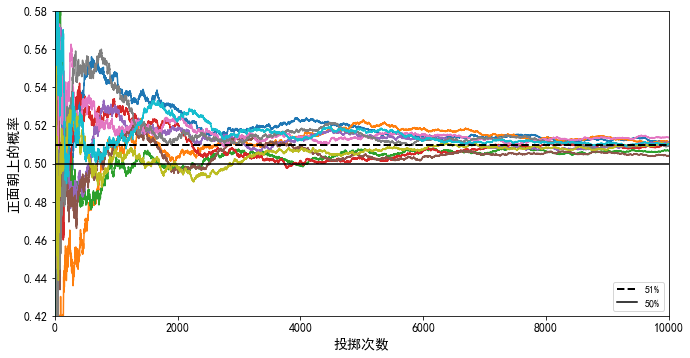

In [6]:
#打印图片
plt.figure(figsize=(11,5.6))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("投掷次数")
plt.ylabel("正面朝上的概率")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

图中显示了10枚硬币的投掷结果，可以看到，随着投掷次数的增加，正面朝上的概率逐渐接近于51%

同样，假设我们创建了一个包含1000个分类器的集成，每个分类器都只有51%的几率是正确的(几乎没比随机猜测强多少)。但是我们以大多数投票的类别作为预测结果，我们可以期待准确率高达75%。
<br>
但是，这基于的前提是:所有分类器都是完全独立的，彼此的错误毫不相关。但这显然是不可能的，因为它们都是在相同的数据上训练的。它们很可能会犯相同的错误，所以也会有很多次大多数投给了错误的类别，导致集成的准确率有所降低。

In [7]:
# 用三个不同分类器组成的投票分类器 来 拟合 月亮数据
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
# 生成数据
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# 分别使用逻辑回归、随机森林、支持向量机算法
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)
# 构成硬投票分类器（合一）
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')# voting = 'hard'根据少数服从多数来定最终结果；

In [9]:
voting_clf.fit(X_train, y_train)#训练

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=42,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=42)),
                             ('svc', SVC(gamma='auto', random_state=42))])

In [10]:
# 可以看到投票分类器略胜于所有单个分类器
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


In [11]:
# 软投票分类器，如果最后能返回估算类别的概率，就可以先对每一类的概率做平均，然后取最值
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')#voting = 'soft'
            #将所有模型预测样本为某一类别的概率的平均值作为标准，概率最高的对应的类型为最终的预测结果；
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=42,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=42)),
                             ('svc',
                              SVC(gamma='auto', probability=True,
                                  random_state=42))],
                 voting='soft')

In [12]:
# 我们可以看到这样效果更好
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


# bagging和pasting
前面提到，获得不同分类器的方法之一是使用不同的训练算法。还有一种方法是每个预测器使用相同的算法，但是在不同的训练子集上进行训练。采样时如果放回，则是bagging(bootstrap aggregating的缩写，也叫自举汇聚法),采样时样本不放回，这种方法则叫做pasting。
<br>
换句话说，bagging和pasting都允许训练实例在多个预测器中被多次采用，但是只有bagging允许训练实例被同一个预测器多次采样。
<br>
一旦预测器训练完成，集成就可以通过简单地聚合所有预测器的预测，来对新实例做出预测。聚合函数通常是统计法(即最多数的预测好比投票分类器一样)用于分类，或是平均法用于回归。每个预测器单独的偏差都高于在原始训练集上训练的偏差，但是通过聚合，同时降低了偏差和方差。总体来说，最终结果是，与直接在原始训练集上训练的单个预测器相比，集成的偏差相近，但是方差更低。
<br>
此外，bagging和pasting可以通过不同的cpu内核甚至不同的服务器，并行地训练预测器。类似的预测也可以，这也是该算法流行的原因之一，非常容易拓展。

![jupyter](./图片/bagging和pasting.png)

# sklearn的bagging和pasting
sklearn集成了一个简单的API，可以用BaggingClassifier进行bagging和pasting的分类工作，BaggingRegerssor进行回归工作

In [13]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# bagging集成 500个决策树，每次随机从训练集采样100个训练实例进行训练，然后放回(bootstrap控制bagging与否)
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

如果基础分类器能够估算类别概率，也就是具备predict_proba方法，比如决策树算法，那么BaggingClassifier就会自动执行软投票法

In [14]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [15]:
# 训练一个单个决策树分类器做对比
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [16]:
from matplotlib.colors import ListedColormap
#用于画图
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    # contour和contourf都是画三维等高线图的，不同点在于contourf会对等高线间的区域进行填充
    # 上色
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        # 画等高线，也就是中间的线
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

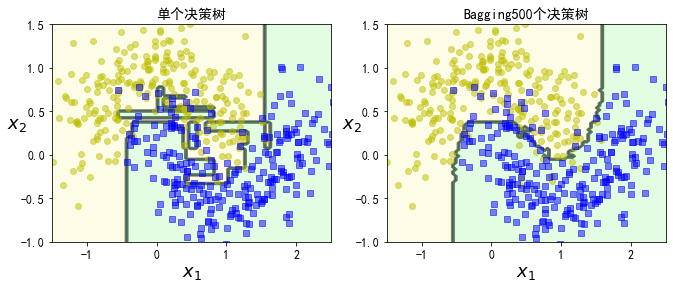

In [17]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("单个决策树", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Bagging500个决策树", fontsize=14)
plt.show()

可以看到，集成预测大泛化效果很可能比单独的决策树要好一点：二者偏差相近，但是集成的方差更小(二者在训练集的错误差不多，但是集成的决策边界更规则)

由于自助法给每个预测器的训练子集引入了更高的多样性，所以bagging会比pasting的偏差略高，但这也意味着预测器之间的关联度更低，所以集成的方差降低。总之，bagging生成的模型通常更好。也可以采用交叉验证来对bagging和pasting的结果做评估，再做抉择。

# 包外评估
对于任意给定的预测器，使用bagging，有些实例可能会被多次采样，而有些实例可能根本不会被采样。BaggingClassifier默认采样m个训练实例，然后放回样本m，m是训练集的大小。这意味着对于每个预测器来说，平均只对63%的训练实例进行采样。剩余37%从未被采样的训练实例称为包外(oob)实例。注意，对于所有预测器来说，这是不一样的37%。
<br>
既然预测器在训练的时候从未见过这些包外的实例，正好可以用这些实例进行评估，从而不需要单独的验证集或是交叉验证。将每个预测器在其包外实例上的评估结果进行平均，就可以得到对集成的评估。

In [18]:
# oob_score 定义是否返回包外评估的分数
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
# 包外评估分数
bag_clf.oob_score_

0.8986666666666666

In [19]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

可以看到包外评估的结果和实际的验证集的结果分数比较接近。

In [20]:
bag_clf.oob_decision_function_[:5]

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

返回正类与负类的概率，例如第二个实例，34.11%左右是正例，65.88%左右是负例

# Random Patches和随机空间
BaggingClassifier也支持对特征进行抽样，这通过max_features和bootstrap_features来控制，工作方式和max_samples，bootstrap相同，只是抽样的不再是实例而是特征。因此，每个预测器将会使用输入特征的随机子集进行训练。
<br>
这对于处理高纬度输入(比如图像)特别有用。对训练实例和特征进行抽样，被称为Random Patches方法。而保留所有训练实例（max_samples=1.0，bootstrap=False）,但是对特征进行抽样（max_features<1.0,bootstrap_features=True），这称为随机子空间法。

# 随机森林
随机森林就是决策树的集成，还可以直接通过RandomForestClassifier/RandomForestReherssor实现。

In [21]:
from sklearn.ensemble import RandomForestClassifier  #随机森林
# RandomForestClassifier拥有决策树和BaggingClassifier的所有超参数，前者控制树的生长，后者控制集成本身。
rnd_clf = RandomForestClassifier(n_estimators=500,  #500棵树
                                 max_leaf_nodes=16,  #每棵树最大16个叶子节点
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [22]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.936

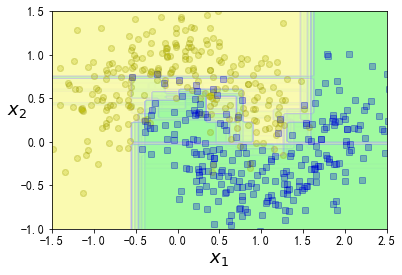

In [23]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

# 极端随机森林
随机森林里单棵树的生长过程中，每个节点在分裂时，仅考虑到了一个随机子集所包含的特征。如果我们对每个特征使用随机阈值，而不是搜索得出的最佳阈值，则可能让树生长得更加随机。
这种极端随机的决策树组成的森林，被称为极端随机树集成。同样，也是以更高的偏差换取了更低的方差。极端随机树训练起来要比常规的随机森林快很多，因为在每个节点上找到每个特征的最佳阈值是决策树生长中最耗时的任务之一。

In [24]:
from sklearn.ensemble import ExtraTreesClassifier  #ExtremelyRandomizedTreesClassifier 极端随机森林
# 500个随机树，限制每棵树最多16个叶节点
# RandomForestClassifier拥有决策树和BaggingClassifier的所有超参数，前者控制树的生长，后者控制集成本身。
et_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
et_clf.fit(X_train, y_train)
y_pred_rf = et_clf.predict(X_test)

In [25]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.92

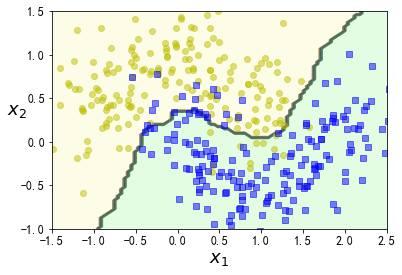

In [26]:
plt.figure(figsize=(6, 4))
plot_decision_boundary(et_clf, X_train, y_train, axes=[-1.5, 2.5, -1, 1.5])
plt.show()

通常来说，很难预测随机森林和极端随机森林那个更好，唯一的方法只能是两者都尝试一遍，然后使用交叉验证进行比较

# 特征重要性
最后，如果查看单个决策树，会发现，重要的特征更可能出现在靠近根节点的位置，而不重要的特征通常出现在靠近叶节点的位置(甚至不出现)。因此，通过计算一个特征在森林中所有树上的平均深度，可以估算一个特征的重要程度。sklearn会在训练结束后自动计算每个特征的重要性。

In [27]:
# 鸢尾花数据训练几个随机森林分类器，并输出特征重要性
#发现花瓣长度和宽度对分类更加重要（40%左右），而萼片的长度和宽度则相对不那么重要（101-23%左右）
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


同样，在MNIST手写数字数据集上训练一个随机森林分类器

In [28]:
try:  #有点慢
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [29]:
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)  #随机森林分类器
rnd_clf.fit(mnist["data"], mnist["target"])  #训练

RandomForestClassifier(n_estimators=10, random_state=42)

In [30]:
def plot_digit(data):  #画图的
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

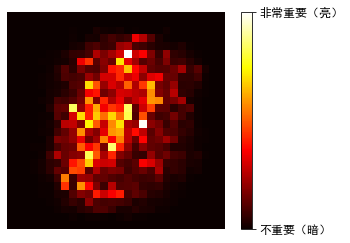

In [31]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['不重要（暗）', '非常重要（亮）'])

plt.show()    #显然，靠近中间的那个范围内像素点更加重要(数据集中字一般都写在中间)

# 提升法
提升法(Boosting,最初被称为假设提升)是指可以将几个弱分类器结合成一个强学习器的任意集成方法。大多数提升法的总体思路是循环训练预测器，每一次都对其前序做出一些改正。可用的提升方法很多，目前最流行的是AdaBoost和梯度提升

# AdaBoost
新预测器对其前序进行纠正的方法之一，就是更多地关注前序拟合不足的训练实例。从而使新的预测器不断地越来越关注难缠的问题，这就是AdaBoost使用的技术。
<br>
例如，要构建一个AdaBoost分类器，首先需要训练一个基础分类器(比如决策树),用它对训练集进行预测，然后对错误分类的训练实例增加其权重，，接着，使用这个新的权重对第二个分类器进行训练，依次迭代循环。
<br>
可以看出AdaBoost这种依序循环的学习技术和梯度下降有异曲同工之妙，区别只在于，梯度下降调节参数使损失函数最小化，而前者则是不断在集成中加入预测器，使模型越来越好。
<br>
这种依序学习技术有个重要的缺陷就是无法并行，因为每个预测器只能在一个预测器训练完成并完成评估之后才能开始训练。因此在拓展方面不如bagging和pasting。
![jupyte](./图片/AdaBoost原理.jpg)

In [32]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),   #使用决策树分类器作为基础预测器
    n_estimators=200,   #最大迭代次数
    algorithm="SAMME.R",#SAMME即用对样本集分类效果作为弱学习器权重，
                        #而SAMME.R使用了对样本集分类的预测概率大小来作为弱学习器权重。
                        #由于SAMME.R使用了概率度量的连续值，迭代一般比SAMME快。
    learning_rate=0.5,   #每个弱学习器的权重缩减系数
    #loss="linear"       #有线性‘linear’(默认), 平方‘square’和指数 ‘exponential’三种选择
    random_state=42)    #随机种子
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

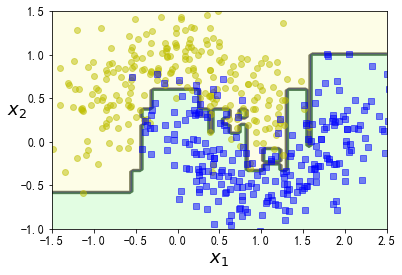

In [33]:
plot_decision_boundary(ada_clf, X, y)

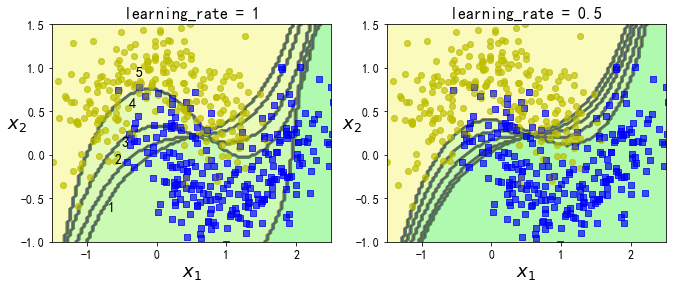

In [34]:
# 使用svm来模拟
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

plt.show()

# 梯度提升
另一个非常受欢迎的提升法师梯度提升。跟AdaBoost一样，梯度提升也是逐步在集成中添加新的预测器，每一个都对其前序做出改正。不同之处在于，它不像AdaBoost那样在每个迭代中调整实例权重，而是让新的预测器对前一个预测器的残差进行拟合。
<br>
来看一个简单的回归示例，使用决策树作为基础预测器，这被称为梯度树提升或者梯度提升回归树(GBRT).

In [35]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [36]:
from sklearn.tree import DecisionTreeRegressor
# 拟合一个
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [38]:
# 对第一个预测器的残差进行拟合第二个
y2 = y - tree_reg1.predict(X)   #减去预测结果
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [39]:
# 对残差进行拟合第三个
y3 = y2 - tree_reg2.predict(X)    #减去预测结果
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [41]:
X_new = np.array([[0.8]])
# 进行预测
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

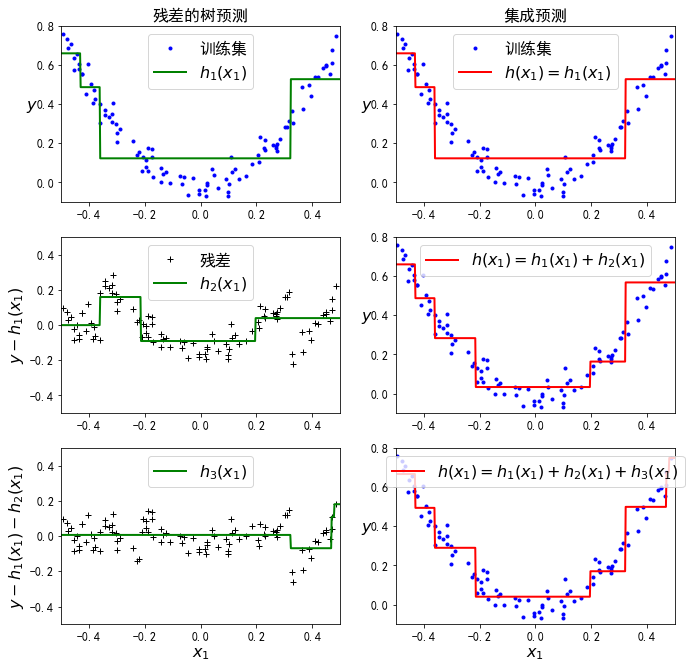

In [44]:
# 进行绘制
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="训练集")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("残差的树预测", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="训练集")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("集成预测", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="残差")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

左侧表示这三棵树的单独预测，右边表示集成的预测。第一行，集成只有一颗树，所以预测与第一棵树的预测完全相同。第二行是在第一棵树的残差的基础上训练的一棵新树，右侧则等于前两个预测之和，依次类推。

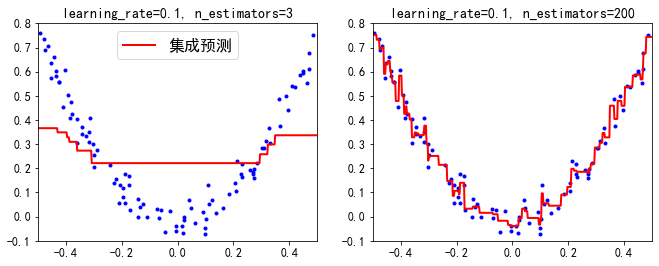

In [46]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1, random_state=42)
gbrt.fit(X, y)

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)


plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="集成预测")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.show()

左边树(预测器)太少，右边太多导致了过拟合<br>
要找到树最佳数量，可以使用早期停止法。对每一个训练阶段验证误差，从而找到最优的树的数量，随后使用最优的树的数量重新训练一个。

In [63]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=100, random_state=66)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [55]:
min_error = np.min(errors)

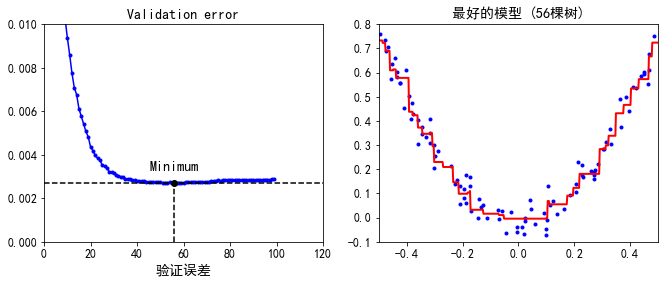

In [64]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("验证误差")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("最好的模型 (%d棵树)" % bst_n_estimators, fontsize=14)
plt.show()

实际上，要实现早期停止法，不一定需要先训练大量的树，然后再回头找最优的数字，还可以真的提前停止训练。通过对warm_start进行设置,skleran，会在调用fit时，保留现有的树，从而允许增量训练，下面代码会在验证误差连续5次迭代未改善时，直接停止训练。

In [65]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

# 堆叠法
最后需要介绍的集成算法是堆叠法，又称为层叠泛化法。它基于一个简单的想法：与其使用一些简单的函数(比如投票)来聚合集成中所有预测器的预测，我们为什么不训练一个模型来执行这个聚合呢？<br>
sklearn暂不支持堆叠